In [1]:
import numpy as np
from pylab import *
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits as fits
from astropy.wcs import WCS
from astropy.table import Table
from scipy.interpolate import griddata
from photutils.aperture import *
from scipy.ndimage import gaussian_filter
from scipy.spatial import *
from sklearn.neighbors import KDTree
from astropy.table import Table
from astropy.table import vstack as vstack_table

from skimage.restoration import denoise_tv_bregman
from scipy.signal import convolve2d
from scipy.spatial import Delaunay
from scipy.spatial import cKDTree
from scipy.spatial import KDTree
from scipy.spatial import ConvexHull
import itertools


from astropy.modeling.models import Gaussian2D
from skimage import color, data, restoration
from mpl_toolkits.axes_grid1 import make_axes_locatable


import re
from os import path
from astropy.nddata import Cutout2D
from reproject import reproject_interp
from collections import Counter
from image_registration import chi2_shift
from my_utils import *
#import naturalneighbor
#import _ngl
#from photutils.aperture import aperture_photometry
from matplotlib.colors import LogNorm
from matplotlib.colors import PowerNorm
#from matplotlib.nxutils import points_inside_poly
from matplotlib.path import Path as mpl_path

import Py3D
from Py3D.functions.rssMethod import *
from Py3D.functions.cubeMethod import *
from scipy.ndimage import shift as shift2D


import pickle
import pyregion
from astropy import coordinates as crd

from cmaps_CLC import vel_map

from photutils.psf import TopHatWindow, create_matching_kernel
from photutils.centroids import (centroid_1dg, centroid_2dg,centroid_com, centroid_quadratic)
from scipy.optimize import curve_fit

1.1.1


In [2]:
from matplotlib import rcParams as rc
rc.update({'font.size': 20,\
           'font.weight': 900,\
           'text.usetex': True,\
           'path.simplify'           :   True,\
           'xtick.labelsize' : 20,\
           'ytick.labelsize' : 20,\
#           'xtick.major.size' : 3.5,\
#           'ytick.major.size' : 3.5,\
           'axes.linewidth'  : 2.0,\
               # Increase the tick-mark lengths (defaults are 4 and 2)
           'xtick.major.size'        :   6,\
           'ytick.major.size'        :   6,\
           'xtick.minor.size'        :   3,\
           'ytick.minor.size'        :   3,\
           'xtick.major.width'       :   1,\
           'ytick.major.width'       :   1,\
           'lines.markeredgewidth'   :   1,\
           'legend.numpoints'        :   1,\
           'xtick.minor.width'       :   1,\
           'ytick.minor.width'       :   1,\
           'legend.frameon'          :   False,\
           'legend.handletextpad'    :   0.3,\
           'font.family'    :   'serif',\
           'mathtext.fontset'        :   'stix',\
           'axes.facecolor' : "w",\
           
          })


In [3]:
def gaus(X,C,X_mean,sigma):
    return C*exp(-(X-X_mean)**2/(2*sigma**2))

In [4]:
def hdu_cen_PS(filename_PS,name='junk',band='g',ext='pdf',A_R=0.0):
    f_cor=1.0
    ww = {'g': 4866, 'r': 6215, 'i': 7545, 'z': 8679, 'y': 9633}
    ww_now = ww[band]
    fname=f'astro_{name}_{band}_new.{ext}'
    hdu_PS = fits.open(filename_PS)[0]
    hdu_PS_org=hdu_PS.copy()
    (ny_PS,nx_PS)=hdu_PS.data.shape
    EXPTIME = hdu_PS.header['EXPTIME']
    wcs_copy = WCS(hdu_PS.header)
    #print(f'CDELT_ORG = {wcs_copy.wcs.cdelt}')
    pix_rat = np.abs(wcs_copy.wcs.cdelt[0]*3600)
    f_ratio = ((10**(-6.64))/EXPTIME)*(((1e-23)*(3e18))/ww_now**2)*1e16/pix_rat**2
    (ny_PS,nx_PS)=hdu_PS.data.shape
    xc_PS = nx_PS/2.0
    yc_PS = ny_PS/2.0 
    hdu_PS.data=hdu_PS.data*10**(0.4*A_R)
    hdu_PS_org.data=hdu_PS_org.data*10**(0.4*A_R)
    #print('xc_PS=',xc_PS,yc_PS, int(1.2*xc_PS),int(1.2*yc_PS))
    img_cut_PS =  Cutout2D(hdu_PS.data.astype(np.float32),\
                           (int(xc_PS),int(yc_PS)), (int(1.2*xc_PS),int(1.2*yc_PS)),wcs=wcs_copy)
    w=img_cut_PS.wcs
    header = w.to_header()
    hdu_PS = fits.PrimaryHDU(header=header)
    hdu_PS.data=img_cut_PS.data
    wcs_copy = WCS(hdu_PS_org.header)
    mag_PS = -2.5*np.log10(np.nansum(hdu_PS.data))+25+2.5*np.log10(EXPTIME)
    hdu_PS.data=hdu_PS.data*f_ratio
    hdu_PS_org.data=hdu_PS_org.data*f_ratio
        
    #print(f'flux_ratio = {f_ratio}')
    (ny_PS,nx_PS)=hdu_PS.data.shape
    wcs = WCS(hdu_PS.header)
    return hdu_PS


In [5]:
#name='NGC5947'
#name='NGC2916'
name='NGC2906'

v23_dir="all_files_v2.3/"
v22_dir="all_files_v2.2/"
PS_dir="./"
out_dir="/disk-a/sanchez/home/sda2/articulos/CALIFA/DR4/astrometry/PSF/"

In [6]:
file_v23_g=v23_dir+'/'+name+'.g.fits.gz'
file_v22_g=v22_dir+'/'+name+'.g.fits.gz'
file_PS_g=PS_dir+'/'+name+'_PS_warp_g.fits'
hdu_v23=fits.open(file_v23_g)
hdu_v22=fits.open(file_v22_g)
hdu_PS=hdu_cen_PS(file_PS_g)

this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


In [7]:
def img_rep(hdu_PS,hdu,ver=1):
    hdu_ref = fits.PrimaryHDU(hdu.data)
    (nx,ny)=hdu.data.shape
    #print(nx,ny)
    wcs_cal = WCS(naxis=2)    
    crpix1_cal=hdu.header['CRPIX1']
    crpix2_cal=hdu.header['CRPIX2']
    cdelt1_cal=hdu.header['CDELT1']
    cdelt2_cal=hdu.header['CDELT2']
    crval1_cal=hdu.header['CRVAL1']
    crval2_cal=hdu.header['CRVAL2']
    #print('WCS_input=',crpix1_cal,crpix2_cal)
    wcs_cal.wcs.crpix = [crpix1_cal,crpix2_cal]
    if (ver==1):
        wcs_cal.wcs.cdelt = np.array([cdelt1_cal,cdelt2_cal])
    else:
        wcs_cal.wcs.cdelt = np.array([(-1)*cdelt1_cal/3600,cdelt2_cal/3600])
    wcs_cal.wcs.crval = [crval1_cal, crval2_cal]
    wcs_cal.wcs.ctype = ["RA---TAN", "DEC--TAN"]
    #wcs_cal.wcs.naxis = [ny,nx]
    hdu_ref.header=wcs_cal.to_header()
    #print(wcs_cal)
    img_PS_to_CAL, footprint_PS_to_CAL = reproject_interp(hdu_PS, hdu_ref.header)
    return img_PS_to_CAL, footprint_PS_to_CAL, wcs_cal
#print(img_PS_to_CAL)


In [8]:
cutW=0.25
#hdu=hdu_v23[0]
#ver='2.3'
#pix_scale=0.5
#img_PS_to_CAL, footprint_PS_to_CAL = img_rep(hdu_PS,hdu,ver=1)
hdu=hdu_v22[0]
ver='2.2'
pix_scale=1.0
img_PS_to_CAL, footprint_PS_to_CAL, wcs_cal = img_rep(hdu_PS,hdu,ver=0)

out_PDF=f'{out_dir}/{name}_v{ver}.pdf'

mask_PS = img_PS_to_CAL>0
g1 = img_PS_to_CAL/img_PS_to_CAL[mask_PS].sum()
mask_CAL = hdu.data > 0
g2 = hdu.data/hdu.data[mask_CAL].sum()
g1[~mask_PS] = 0
g2[~mask_CAL] = 0
window = TopHatWindow(cutW)
kernel = create_matching_kernel(g1, g2, window=window)
xc, yc = centroid_quadratic(kernel)
(ny,nx)=kernel.shape
#print(xc,yc)
xc=xc+0.5
yc=yc+0.5
sec = kernel[int(yc-0.15*ny):int(yc+0.15*ny),int(xc-0.15*nx):int(xc+0.15*nx)]
xc, yc = centroid_quadratic(sec)
x_cut = sec[int(yc),:]
y_cut = sec[:,int(xc)]
X_x_cut=np.arange(len(x_cut))
param_optimised_x,param_covariance_matrix_x = curve_fit(gaus,X_x_cut,x_cut,p0=[1,len(X_x_cut)/2,1],maxfev=5000)
x_model = gaus(X_x_cut,*param_optimised_x)
#print('GAUS X=',param_optimised_x)
X_y_cut=np.arange(len(y_cut))
param_optimised_y,param_covariance_matrix_x = curve_fit(gaus,X_y_cut,y_cut,p0=[1,len(X_y_cut)/2,1],maxfev=5000)
y_model = gaus(X_y_cut,*param_optimised_y)
#print('GAUS Y=',param_optimised_y)
fwhm_x=param_optimised_x[2]*pix_scale
fwhm_y=param_optimised_y[2]*pix_scale

fwhm_x = np.round(np.sqrt(fwhm_x**2+1.31**2),2)
fwhm_y = np.round(np.sqrt(fwhm_y**2+1.31**2),2)
fwhm_v22=(fwhm_x+fwhm_y)/2
#print(param_covariance_matrix_x)

<ipython-input-9-aedfbb0fd24d>:9: RuntimeWarning: invalid value encountered in log10
  ax1.imshow(np.log10(hdu_PS.data),origin='lower',cmap=new_cmap)
<ipython-input-9-aedfbb0fd24d>:16: RuntimeWarning: divide by zero encountered in log10
  ax2.imshow(np.log10(g1),origin='lower',cmap=new_cmap)
<ipython-input-9-aedfbb0fd24d>:17: RuntimeWarning: divide by zero encountered in log10
  ax3.imshow(np.log10(g2),origin='lower',cmap=new_cmap)


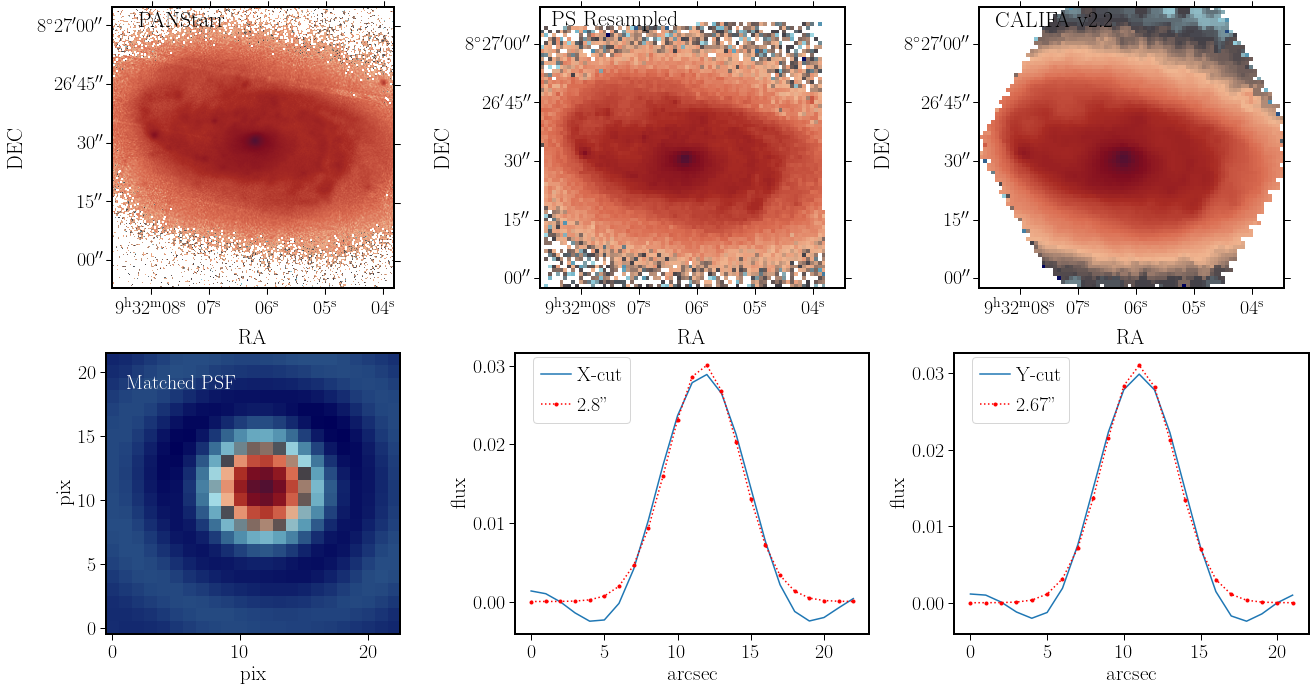

In [9]:
#fig, ax =plt.subplots(2,3,figsize=(16,8))
#gs = fig.add_gridspec(2,3)
fig=plt.figure(figsize=(18.15,10))
new_cmap=vel_map()
(ny,nx) = g1.shape
gs = fig.add_gridspec(2,3)
wcs_PS = WCS(hdu_PS.header)
ax1=fig.add_subplot(gs[0,0],projection=wcs_PS)
ax1.imshow(np.log10(hdu_PS.data),origin='lower',cmap=new_cmap)
ax2=fig.add_subplot(gs[0,1],projection=wcs_cal)
ax3=fig.add_subplot(gs[0,2],projection=wcs_cal)
ax4=fig.add_subplot(gs[1,0])
ax5=fig.add_subplot(gs[1,1])
ax6=fig.add_subplot(gs[1,2])

ax2.imshow(np.log10(g1),origin='lower',cmap=new_cmap)
ax3.imshow(np.log10(g2),origin='lower',cmap=new_cmap)
ax4.imshow(sec,origin='lower',cmap=new_cmap)
ax5.plot(X_x_cut*pix_scale,x_cut,label='X-cut')
ax5.plot(X_x_cut*pix_scale,x_model,'r.:',label=f'{fwhm_x}\"')
ax6.plot(X_y_cut*pix_scale,y_cut,label='Y-cut')
ax6.plot(X_y_cut*pix_scale,y_model,'r.:',label=f'{fwhm_y}\"')
ax1.set_title('PANStarr',fontsize=22, x=0.25,y=1.0, pad=-20)
#ax1.text(0.05*nx,0.85*ny,'Matched PSF',color='white')
ax1.set_xlabel('RA',fontsize=21)
ax1.set_ylabel('DEC',fontsize=21)
ax2.set_title('PS Resampled',fontsize=22, x=0.25,y=1.0, pad=-20)#,fontsize=21)
ax2.set_xlabel('RA',fontsize=21)
ax2.set_ylabel('DEC',fontsize=21)
ax3.set_title(f'CALIFA v{ver}',fontsize=22, x=0.25,y=1.0, pad=-20)#,fontsize=21)
ax3.set_xlabel('RA',fontsize=21)
ax3.set_ylabel('DEC',fontsize=21)
#ax4.set_title('Matched PSF',fontsize=21)
(nny,nnx)=sec.shape
ax4.text(0.05*nnx,0.85*nny,'Matched PSF',color='white')
ax4.set_xlabel('pix',fontsize=21)
ax4.set_ylabel('pix',fontsize=21)
#ax5.set_title('PSF:X-axis cut',fontsize=21)
ax5.set_xlabel('arcsec',fontsize=21)
ax5.set_ylabel('flux',fontsize=21)
#ax6.set_title('PSF:Y-axis cut',fontsize=21)
ax6.set_xlabel('arcsec',fontsize=21)
ax6.set_ylabel('flux',fontsize=21)


#
handles, labels = ax5.get_legend_handles_labels()
ax5.legend(handles, labels,loc=(0.05,0.75),frameon=True,handlelength=1.5)  
handles, labels = ax6.get_legend_handles_labels()
ax6.legend(handles, labels,loc=(0.05,0.75),frameon=True,handlelength=1.5)  
    
fig.tight_layout(w_pad=1.0,h_pad=3.0)
fig.savefig(out_PDF, transparent=False, facecolor='white', edgecolor='white')#.pdf")


#fig.legend()

#ax[1][0].imshow(kernel[int(0.4*ny):int(0.6*ny),int(0.4*nx):int(0.6*nx)],origin='lower')
#plt.show()



In [10]:
hdu=hdu_v23[0]
ver='2.3'
pix_scale=0.5
img_PS_to_CAL, footprint_PS_to_CAL,wcs_cal = img_rep(hdu_PS,hdu,ver=1)
#hdu=hdu_v22[0]
#ver='2.2'
#pix_scale=1.0
#img_PS_to_CAL, footprint_PS_to_CAL, wcs_cal = img_rep(hdu_PS,hdu,ver=0)

out_PDF=f'{out_dir}/{name}_v{ver}.pdf'

mask_PS = img_PS_to_CAL>0
g1 = img_PS_to_CAL/img_PS_to_CAL[mask_PS].sum()
mask_CAL = hdu.data > 0
g2 = hdu.data/hdu.data[mask_CAL].sum()
g1[~mask_PS] = 0
g2[~mask_CAL] = 0
window = TopHatWindow(cutW)
kernel = create_matching_kernel(g1, g2, window=window)
xc, yc = centroid_quadratic(kernel)
#print(xc,yc)
xc=xc+0.5
yc=yc+0.5
sec = kernel[int(yc-0.15*ny):int(yc+0.15*ny),int(xc-0.15*nx):int(xc+0.15*nx)]
xc, yc = centroid_quadratic(sec)
x_cut = sec[int(yc),:]
y_cut = sec[:,int(xc)]
X_x_cut=np.arange(len(x_cut))
param_optimised_x,param_covariance_matrix_x = curve_fit(gaus,X_x_cut,x_cut,p0=[1,len(X_x_cut)/2,1],maxfev=5000)
x_model = gaus(X_x_cut,*param_optimised_x)
#print('GAUS X=',param_optimised_x)
X_y_cut=np.arange(len(y_cut))
param_optimised_y,param_covariance_matrix_x = curve_fit(gaus,X_y_cut,y_cut,p0=[1,len(X_y_cut)/2,1],maxfev=5000)
y_model = gaus(X_y_cut,*param_optimised_y)
#print('GAUS Y=',param_optimised_y)
fwhm_x=param_optimised_x[2]*pix_scale
fwhm_y=param_optimised_y[2]*pix_scale

fwhm_x = np.round(np.sqrt(fwhm_x**2+1.31**2),2)
fwhm_y = np.round(np.sqrt(fwhm_y**2+1.31**2),2)
fwhm_v23=(fwhm_x+fwhm_y)/2


<ipython-input-11-aedfbb0fd24d>:9: RuntimeWarning: invalid value encountered in log10
  ax1.imshow(np.log10(hdu_PS.data),origin='lower',cmap=new_cmap)
<ipython-input-11-aedfbb0fd24d>:16: RuntimeWarning: divide by zero encountered in log10
  ax2.imshow(np.log10(g1),origin='lower',cmap=new_cmap)
<ipython-input-11-aedfbb0fd24d>:17: RuntimeWarning: divide by zero encountered in log10
  ax3.imshow(np.log10(g2),origin='lower',cmap=new_cmap)


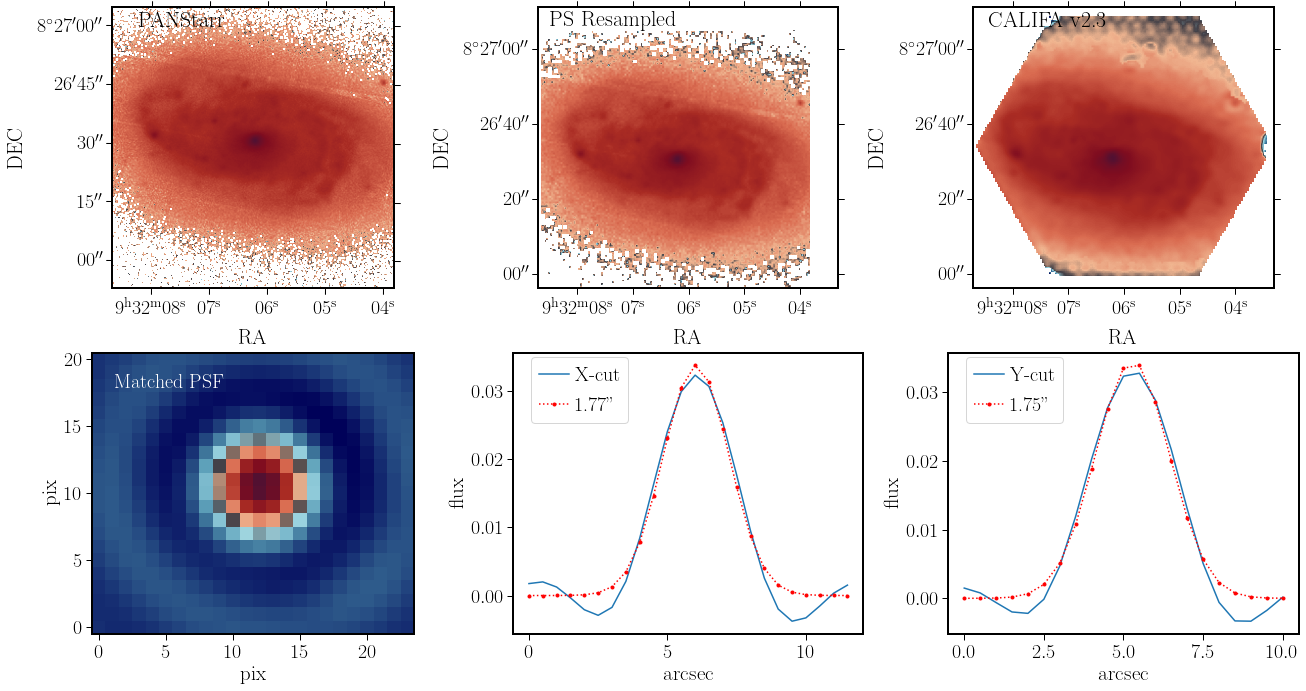

In [11]:
#fig, ax =plt.subplots(2,3,figsize=(16,8))
#gs = fig.add_gridspec(2,3)
fig=plt.figure(figsize=(18.15,10))
new_cmap=vel_map()
(ny,nx) = g1.shape
gs = fig.add_gridspec(2,3)
wcs_PS = WCS(hdu_PS.header)
ax1=fig.add_subplot(gs[0,0],projection=wcs_PS)
ax1.imshow(np.log10(hdu_PS.data),origin='lower',cmap=new_cmap)
ax2=fig.add_subplot(gs[0,1],projection=wcs_cal)
ax3=fig.add_subplot(gs[0,2],projection=wcs_cal)
ax4=fig.add_subplot(gs[1,0])
ax5=fig.add_subplot(gs[1,1])
ax6=fig.add_subplot(gs[1,2])

ax2.imshow(np.log10(g1),origin='lower',cmap=new_cmap)
ax3.imshow(np.log10(g2),origin='lower',cmap=new_cmap)
ax4.imshow(sec,origin='lower',cmap=new_cmap)
ax5.plot(X_x_cut*pix_scale,x_cut,label='X-cut')
ax5.plot(X_x_cut*pix_scale,x_model,'r.:',label=f'{fwhm_x}\"')
ax6.plot(X_y_cut*pix_scale,y_cut,label='Y-cut')
ax6.plot(X_y_cut*pix_scale,y_model,'r.:',label=f'{fwhm_y}\"')
ax1.set_title('PANStarr',fontsize=22, x=0.25,y=1.0, pad=-20)
#ax1.text(0.05*nx,0.85*ny,'Matched PSF',color='white')
ax1.set_xlabel('RA',fontsize=21)
ax1.set_ylabel('DEC',fontsize=21)
ax2.set_title('PS Resampled',fontsize=22, x=0.25,y=1.0, pad=-20)#,fontsize=21)
ax2.set_xlabel('RA',fontsize=21)
ax2.set_ylabel('DEC',fontsize=21)
ax3.set_title(f'CALIFA v{ver}',fontsize=22, x=0.25,y=1.0, pad=-20)#,fontsize=21)
ax3.set_xlabel('RA',fontsize=21)
ax3.set_ylabel('DEC',fontsize=21)
#ax4.set_title('Matched PSF',fontsize=21)
(nny,nnx)=sec.shape
ax4.text(0.05*nnx,0.85*nny,'Matched PSF',color='white')
ax4.set_xlabel('pix',fontsize=21)
ax4.set_ylabel('pix',fontsize=21)
#ax5.set_title('PSF:X-axis cut',fontsize=21)
ax5.set_xlabel('arcsec',fontsize=21)
ax5.set_ylabel('flux',fontsize=21)
#ax6.set_title('PSF:Y-axis cut',fontsize=21)
ax6.set_xlabel('arcsec',fontsize=21)
ax6.set_ylabel('flux',fontsize=21)


#
handles, labels = ax5.get_legend_handles_labels()
ax5.legend(handles, labels,loc=(0.05,0.75),frameon=True,handlelength=1.5)  
handles, labels = ax6.get_legend_handles_labels()
ax6.legend(handles, labels,loc=(0.05,0.75),frameon=True,handlelength=1.5)  
    
fig.tight_layout(w_pad=1.0,h_pad=3.0)
fig.savefig(out_PDF, transparent=False, facecolor='white', edgecolor='white')#.pdf")


#fig.legend()

#ax[1][0].imshow(kernel[int(0.4*ny):int(0.6*ny),int(0.4*nx):int(0.6*nx)],origin='lower')
#plt.show()



In [12]:
print(f'{name},{fwhm_v23},{fwhm_v22}')

NGC2906,1.76,2.735
